In [2]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize 
import csv
import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

Read CSV data

In [3]:
# read csv data
data = pd.read_csv("Sinhala_Singlish_Hate_Speech.csv")

Data preprocessing

In [4]:
# preporocessing texts
def preporocessingText(sentence):
    #regex for html tags cleaner 
    cleaner_htmlTags  = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext_htmltags = re.sub(cleaner_htmlTags, '',sentence).lower()   #convert to lower case
    
    #regex for non alphabetical characters cleaner
    cleantext_NonAlp = re.compile(u'[^\u0061-\u007A|^\u0D80-\u0DFF|^\u0030-\u0039]', re.UNICODE)
    #Englosh lower case unicode range = \u0061-\u007A 
    #Sinhala unicode range = |u0D80-\u0DFF
    #Numbers unicode range = \u0030-\u0039 
    
    cleantext_finalText = re.sub(cleantext_NonAlp, ' ',cleantext_htmltags).strip(" ")
    
    #tokenzing
    #finalText = word_tokenize(cleantext_finalText)
    #finalText = sent_token = nltk.sent_tokenize(tokenzie_finalText)

    #return finalText
    return cleantext_finalText

check is whether sentesnces has full english letters(romanized sinhala) or mix of english & sinhala words

In [5]:
def isSinglish(sentence):
    try:
        sentence.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True


Generate two separe dataframes(romanized sinhala and mix of english & sinhala words)

In [7]:
# genarate separate dataframes
df_Sinhala  = pd.DataFrame(columns=['PhraseNo', 'Phrase', 'IsHateSpeech'])
df_Singlish = pd.DataFrame(columns=['PhraseNo', 'Phrase', 'IsHateSpeech'])
df_All_preprocess = pd.DataFrame(columns=['PhraseNo', 'Phrase', 'IsHateSpeech'])


singish_index = 1
sinhala_index = 1

for i in range(data.shape[0]):
    dataSentence = data['Phrase'][i]
    preprocessData = preporocessingText(dataSentence)

    if(isSinglish(dataSentence)):
        df_Singlish.loc[singish_index-1] = [singish_index] + [preprocessData] + [data['IsHateSpeech'][i]]
        singish_index += 1
        
    else:
        df_Sinhala.loc[sinhala_index-1] = [sinhala_index] + [preprocessData] + [data['IsHateSpeech'][i]]
        sinhala_index += 1 
    df_All_preprocess.loc[i] = [i+1] + [preprocessData] + [data['IsHateSpeech'][i]]
        
#df_Sinhala.to_csv('Sinhala_hatespeech.csv')
#df_Singlish.to_csv('Singlish_hatespeech.csv')
#df_All_preprocess.to_csv('AllPreProcess_hatespeech.csv')

Print percentage of the data

In [8]:
sinhala_sent_percentage = (sinhala_index/data.shape[0])*100
singlish_sent_percentage = (singish_index/data.shape[0])*100
print("Sinhala sentences percentage(mix sinhala and english letters)  = ",str(sinhala_sent_percentage)+" %")
print("Singlish sentences percentage(only has english letters) = ",str(singlish_sent_percentage) +" %")

Sinhala sentences percentage(mix sinhala and english letters)  =  72.48 %
Singlish sentences percentage(only has english letters) =  27.6 %


In [10]:
def getUniqueTokens(myarr):
    myset = list(set(myarr))
    return myset

def joinWordsIntoSentence(dataframe):
    for itm in range(len(dataframe)):
        words_arr = dataframe['Phrase'][itm]
        dataframe['Phrase'][itm] = ( " ".join( words_arr ))

### For Sinhala Dataset(has sinhala end english words)

#### Sinhala stop words removal

In [12]:
#getting the stop words
f_stopWords = io.open("StopWords_425.txt", mode="r", encoding="utf-16")
sinhala_stop_words = []
df_StopWordsRemoval_Sinhala = pd.DataFrame(columns=['PhraseNo', 'Phrase', 'IsHateSpeech'])

for x in f_stopWords:
  sinhala_stop_words.append(x.split()[0])



In [13]:
SinhalaData = df_Sinhala
prev_lengths_arr = []
prev_lengths_arr_unique = []
after_removal_stopWords_lenghts_arr = []
after_removal_stopWords_lenghts_arr_unique = [] 

for k in range(SinhalaData.shape[0]):
    SentenceTokens = word_tokenize(SinhalaData['Phrase'][k])
    
    prev_lengths_arr.append(len(SentenceTokens))
    #print(len(SentenceTokens))
    prev_lengths_arr_unique.append(len(getUniqueTokens(SentenceTokens)))
    #remove stop words
    removing_stopwords_sentence = [word for word in SentenceTokens if word not in sinhala_stop_words]
    after_removal_stopWords_lenghts_arr.append(len(removing_stopwords_sentence))
    after_removal_stopWords_lenghts_arr_unique.append(len(getUniqueTokens(removing_stopwords_sentence)))
    #print(removing_stopwords_sentence)
    df_StopWordsRemoval_Sinhala.loc[k] = [k+1] + [removing_stopwords_sentence] + [SinhalaData['IsHateSpeech'][k]]
    

joinWordsIntoSentence(df_StopWordsRemoval_Sinhala )

In [14]:
df_StopWordsRemoval_Sinhala

,PhraseNo,Phrase,IsHateSpeech
0,1,බැල්ලි කොටින්ගේ ගු කනකොට අපහසුවක් දැනුනෙ දන් ඔ...,YES
1,2,මන් ඊයේ මුස්ලිම් ඩෑල් එකක් සෙල්ෆියක් ගත්තා සහජ...,YES
2,3,සංහිදියාවට අවුලක් වෙයි,NO
3,4,කටින් පුරසාරම් දොඩන අපි සිංහලයො විදියට ලැජ්ජා ...,YES
4,5,මචන් මගුල නවත්තලා කොන්දක් තියෙනවානම් පුලුවන්නම...,YES
...,...,...,...
1806,1807,දෙන්නා එකතු වෙලා tv program එකක් කරන්නකො තියන ...,NO
1807,1808,මොනා කිව්වත් ඔයාල දෙන්නගෙ කටවල් දෙකට ගහන්න ලංක...,NO
1808,1809,ඇස්වහ කටවහක් ඔයාලා දෙනාටම හැමදාමත් අපිව සතුටින...,NO
1809,1810,මුන් දෙන්න රෙඩියෝ එකේ සුපිරි ඩබල හිරු ඉන්න කාල...,NO


Drwaing a bar histograms to show sentences lenghts distribution

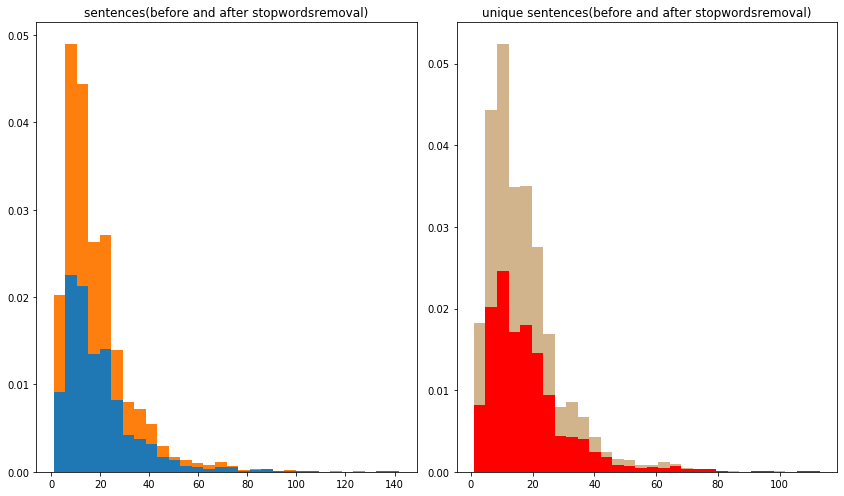

In [15]:
preLenghts = prev_lengths_arr
afterLenghts = after_removal_stopWords_lenghts_arr
preLenghtsUnique = prev_lengths_arr_unique
afterLenghtsUnique = after_removal_stopWords_lenghts_arr_unique

arr1 = []
arr2 = []
for i in range(len(preLenghts)):
    ar_i = []
    ar_i.append(preLenghts[i])
    ar_i.append(afterLenghts[i])
    arr1.append(ar_i)
    
    ar_j = []
    ar_j.append(preLenghtsUnique[i])
    ar_j.append(afterLenghtsUnique[i])
    arr2.append(ar_j)
    
import numpy as np
myarray1 = np.asarray(arr1)
myarray2 = np.asarray(arr2)


import matplotlib.pyplot as plt

np.random.seed(19680801)

n_bins = 30
x = np.random.randn(1000, 3)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 7))
ax0, ax1 = axes.flatten()

colors = ['red', 'tan']


ax0.hist(myarray1, n_bins, density=True, histtype='bar', stacked=True,label=colors)
ax0.set_title('sentences(before and after stopwordsremoval)')

ax1.hist(myarray2, n_bins, density=True, histtype='bar', stacked=True,color=colors, label=colors)
ax1.set_title('unique sentences(before and after stopwordsremoval)')



fig.tight_layout()
plt.show()

In [16]:
print("Max length(previous) = ",max(prev_lengths_arr))
print("Max length(after removal of stopwords) = ",max(after_removal_stopWords_lenghts_arr))
print()
print("Min length(previous) = ",min(prev_lengths_arr))
print("Min length(after removal of stopwords) = ",min(after_removal_stopWords_lenghts_arr))

Max length(previous) =  142
Max length(after removal of stopwords) =  126

Min length(previous) =  2
Min length(after removal of stopwords) =  1


#### Sinhala steming

In [18]:
f_suffixes = io.open("Suffixes-413.txt", mode="r", encoding="utf-16")
sinhala_suffixes = []
df_Stemming_Sinhala = pd.DataFrame(columns=['PhraseNo', 'Phrase', 'IsHateSpeech'])
afterStemingLenghtsUnique = []

for suf in f_suffixes:
  sinhala_suffixes.append(suf.strip().split()[0])

In [19]:
def isSuffix(s1, s2): 
      
    n1 = len(s1) 
    n2 = len(s2) 
    if (n1 > n2): 
        return False
    for i in range(n1): 
        if(s1[n1 - i - 1] != s2[n2 - i - 1]): 
            return False
    return True

def removeSuffix(word,suffix):
    newLen = len(word)-len(suffix)
    wordN = word[0:newLen]
    return wordN

In [20]:
def stemming(data_frame):
    stems = {}
    found = 0
    df_Stemming = pd.DataFrame(columns=['PhraseNo', 'Phrase', 'IsHateSpeech'])
    for r in range(data_frame.shape[0]):
        Sentence = data_frame['Phrase'][r]
        #print(Sentence)
        SentenceTokens = word_tokenize(Sentence)
        stemming_sentence_n = []
        for wr in SentenceTokens:
            found = 0
            for suf in sinhala_suffixes:
                if(isSuffix(suf.strip(),wr.strip())):
                    stm = removeSuffix(wr.strip(),suf.strip())
                    stems[wr] = stm
                    stemming_sentence_n.append(stems[wr])
                    found = 1
                    break
            
            if(found == 0):
                stemming_sentence_n.append(wr)
                
        #print(stemming_sentence_n)
        df_Stemming.loc[r] = [r+1] + [stemming_sentence_n] + [data_frame['IsHateSpeech'][r]]
        stemming_sentence_n = []
        #print(stemming_sentence_n)
    print(stems)
    joinWordsIntoSentence(df_Stemming)
    return df_Stemming


In [21]:
df_Stemming_Sinhala = stemming(df_StopWordsRemoval_Sinhala)

{'කොටින්ගේ': 'කොටින්', 'ගු': 'ග', 'කනකොට': 'කනකො', 'අපහසුවක්': 'අපහසුවක', 'දැනුනෙ': 'දැනුන', 'දන්': 'දන', 'ඔකිට': 'ඔ', 'මිනිහා': 'මිනිහ', 'මැරුනම': 'මැරුන', 'දැනුන': 'දැනු', 'දුකට': 'දු', 'දහස්': 'දහස', 'ගුනයක': 'ගුනය', 'දුකක්': 'දුකක', 'දැනෙනවා': 'දැනෙ', 'ඉස්සරහට': 'ඉස්සරහ', 'උපසම්පදාව': 'උපසම්පදා', 'තියන': 'තිය', 'භික්සුවක්': 'භික්සුවක', 'හිරේ': 'හිර', 'යැවුවට': 'යැවුව', 'ඔකි': 'ඔ', 'වැඩියෙන්ම': 'වැඩියෙන්', 'ආදරේ': 'ආදර', 'කෙනෙක්': 'කෙනෙක', 'නැති': 'නැ', 'වෙනවා': 'වෙ', 'කල්': 'කල', 'නොගිහින්': 'නොගිහින', 'මන්': 'මන', 'ඊයේ': 'ඊ', 'මුස්ලිම්': 'මුස්ලිම', 'ඩෑල්': 'ඩෑල', 'එකක්': 'එකක', 'සෙල්ෆියක්': 'සෙල්ෆියක', 'ගත්තා': 'ගත්ත', 'සහජීවනේ': 'සහජීවන', 'රැකගෙන': 'රැකගෙ', 'යන්න': 'යන්', 'ඒක': 'ඒ', 'තාම': 'තා', 'දාලා': 'දා', 'පරයා': 'පර', 'සංහිදියාවට': 'සංහිදියාව', 'අවුලක්': 'අවුලක', 'වෙයි': 'වෙ', 'කටින්': 'කටින', 'පුරසාරම්': 'පුරසාරම', 'දොඩන': 'දොඩ', 'සිංහලයො': 'සිංහලය', 'විදියට': 'විදිය', 'ලැජ්ජා': 'ලැජ්ජ', 'විය': 'වි', 'යුතුයි': 'යුතු', 'මචන්': 'මචන', 'මගුල': 'මගු', 'නවත්තලා': 'නවත්ත', 'කොන්ද

In [22]:
df_Stemming_Sinhala

,PhraseNo,Phrase,IsHateSpeech
0,1,බැල්ලි කොටින් ග කනකො අපහසුවක දැනුන දන ඔ මිනිහ ...,YES
1,2,මන ඊ මුස්ලිම ඩෑල එකක සෙල්ෆියක ගත්ත සහජීවන රැකග...,YES
2,3,සංහිදියාව අවුලක වෙ,NO
3,4,කටින පුරසාරම දොඩ අපි සිංහලය විදිය ලැජ්ජ වි යුතු,YES
4,5,මචන මගු නවත්ත කොන්දක තියෙනවානම පුලුවන්නම කර පෙ...,YES
...,...,...,...
1806,1807,දෙන් එකත වෙ tv program එකක කරන්නක තිය talent ඒ...,NO
1807,1808,මො කිව්වත ඔයා දෙන්න කටවල දෙ ගහන් ලංකා කටක පට්,NO
1808,1809,ඇස්වහ කටවහක ඔයා දෙනා හැමදාමත අපි සතුටින තියන් ...,NO
1809,1810,මුන දෙන් රෙඩි එ සුපිරි ඩබ හිර ඉන් කාල ඉදන අහ d...,NO


### Bag of Words approach

training and test data separation

In [24]:

from sklearn.model_selection import train_test_split

X = df_Stemming_Sinhala["Phrase"]
y = df_Stemming_Sinhala["IsHateSpeech"]
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size = 0.2, random_state = 0)


In [25]:
def create_bag_of_words(X):
    from sklearn.feature_extraction.text import CountVectorizer
    
    print ('Creating bag of words...')
    # Initialize the "CountVectorizer" object
    
    # In this example features may be single words or two consecutive words
    vectorizer = CountVectorizer()

    
    train_data_features = vectorizer.fit_transform(X)
    
    # Convert to a NumPy array for easy of handling
    train_data_features = train_data_features.toarray()
   
    # Take a look at the words in the vocabulary
    vocab = vectorizer.get_feature_names()
    print ('Created')
    return vectorizer, vocab, train_data_features

In [26]:
vectorizer, vocab, train_data_features  = (
        create_bag_of_words(X_train))

Creating bag of words...
Created


In [27]:
vocab

['00',
 '000',
 '000ක',
 '02',
 '0711595306',
 '0හ',
 '0හලයන',
 '10',
 '100',
 '10000ක',
 '1002',
 '100ය',
 '10ක',
 '13',
 '15000',
 '15k',
 '15ක',
 '17',
 '18',
 '19',
 '1910',
 '1920',
 '1ක',
 '20',
 '200',
 '2006',
 '200ක',
 '2015',
 '2018',
 '2020',
 '21',
 '22',
 '225',
 '225ක',
 '24',
 '25',
 '250',
 '2500',
 '25ක',
 '275',
 '2ක',
 '30',
 '3000',
 '31',
 '313',
 '31ක',
 '320km',
 '350',
 '365',
 '3rd',
 '3ක',
 '3න',
 '40',
 '400ක',
 '49ක',
 '4x4',
 '50',
 '500',
 '500ක',
 '56ක',
 '5tama',
 '60ක',
 '650',
 '700',
 '75ක',
 '77',
 '84',
 '88',
 '89',
 '94',
 '95',
 '99',
 '99ක',
 'ac',
 'account',
 'achieve',
 'actress',
 'ad',
 'ada',
 'adaganada',
 'add',
 'address',
 'aelluvata',
 'ahapan',
 'ahenam',
 'ahinsaka',
 'ahinsakaya',
 'ai',
 'ain',
 'aiya',
 'aiye',
 'aiyooooooo',
 'akai',
 'akak',
 'akata',
 'akkai',
 'aklpa',
 'aktath',
 'al',
 'all',
 'allanna',
 'allow',
 'aloysiusta',
 'also',
 'aluth',
 'amaru',
 'amma',
 'ammata',
 'ammo',
 'ancer',
 'and',
 'anduwa',
 'ane',
 

In [28]:
train_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [29]:
def train_logistic_regression(features, label):
    print ("Training model........")
    from sklearn.linear_model import LogisticRegression
    #ml_model = LogisticRegression(C = 100,random_state = 0)
    ml_model = LogisticRegression()
    ml_model.fit(features, label)
    print ('Created')
    return ml_model

In [30]:
def generateModel(vectorizer,train_data_featres,train_data,test_data):
    ml_modelp = train_logistic_regression(train_data_featres, train_data)
    
    ml_model_before = ml_modelp
    test_data_featuresp = vectorizer.transform(test_data)
    # Convert to numpy array
    test_data_featuresp = test_data_featuresp.toarray()
    
    predicted_modl = ml_modelp.predict(test_data_featuresp)
    
    return ml_model_before,predicted_modl

In [35]:
ml_model_before_1,predicdedModel_1 = generateModel(vectorizer,train_data_features,y_train,X_test)

Training model........
Created


In [36]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import numpy as np

# Define function to calculate the 4 common mertics
def get_metrics(true_labels, predicted_labels):
    correctly_identified_y = predicted_labels == true_labels
    
    print("Confusion metrix: ")
    confusion_met = confusion_matrix(true_labels, predicted_labels)
    print(confusion_met)
    print()
    
    accuracy = np.mean(correctly_identified_y) * 100
    print ('Accuracy = %.0f%%' %accuracy)
    
    precision = (confusion_met[0][0]/(confusion_met[0][0]+confusion_met[1][0]))* 100
    print ('precision = %.1f%%' %precision)
    
    recall = (confusion_met[0][0]/(confusion_met[0][0]+confusion_met[0][1]))* 100
    print ('recall = %.1f%%' %recall)
    
    F1_Score = 2*((precision*recall)/(precision+recall))
    print ('F1 Score = %.1f%%' %F1_Score)

In [37]:
get_metrics(y_test,predicdedModel_1)

Confusion metrix: 
[[146  39]
 [ 65 113]]

Accuracy = 71%
precision = 69.2%
recall = 78.9%
F1 Score = 73.7%


### For Singlish(only include english letters)

no need to do the stopewords removal and stemming since there are no any methods have been founds for these words

In [39]:
SinglishData = df_Singlish

In [ ]:
df_Singlish_unique = pd.DataFrame(columns=['PhraseNo', 'Phrase', 'IsHateSpeech'])
prev_lengths_arr_singlish = []
after_unique_arr_singlish = []

for r in range(SinglishData.shape[0]):
     Sentence_singlish = word_tokenize(SinglishData['Phrase'][r])
     prev_lengths_arr_singlish.append(len(Sentence_singlish))
     unique_sentence = getUniqueTokens(Sentence_singlish)
     df_Singlish_unique.loc[r] = [r+1] + [unique_sentence] + [SinglishData['IsHateSpeech'][r]]
        
     after_unique_arr_singlish.append(len(unique_sentence))
    
joinWordsIntoSentence(df_Singlish_unique)    